In [48]:
#IMPORTS

import os
import cv2
import json
import torch
import random
import numpy as np
import pathlib as pl
import matplotlib.pyplot### CLASSES as plt

from PIL import Image, ImageDraw
#from google.colab.patches import cv2_imshow

In [49]:
class LabelmeDataloader(torch.utils.data.Dataset):
    """Dataloader for Labelme json format"""

    def __init__(self, json_folder, class_to_id):
        """
        :param images_folder: String with the path of the folder containing the images
        :param xml_filename: String with the filename of the output of the CVAT
        :param class_to_id: Dictionary. {'class_name':id, ...}
        :param augmentation: Bool defining if there is data augmentation or not
        :param max_side: Size of the biggest side of the image
        """
         
        self.json_file_list = []
            
        json_folder = pl.Path(json_folder)
        
        json_files = json_folder.glob('*.json')
        
        for json_file in json_files:
            
            img_file = json_file.parent / (json_file.stem + '.png')
            
            if not img_file.exists():
                print('Could not match json %s with image %s' % (json_file, img_file))
                continue
                
            self.json_file_list.append(json_file)

        self.class_to_id = class_to_id
        
        tuple_items = ()
        for key, _ in self.class_to_id.items():
            if key != 'dontcare':
                tuple_items += (key,)

        self.tuple_classes = tuple_items

    def __len__(self):
        
        return len(self.json_file_list)

    def __getitem__(self, idx):
        
        json_file = self.json_file_list[idx]
        img_file = json_file.parent / (json_file.stem + '.png')

        with open(json_file, 'r') as f:
            json_gt = json.load(f)
            
        img = cv2.imread(str(img_file), cv2.IMREAD_COLOR)[..., ::-1]

        shape = img.shape
        
        # Creates label image and sets everything to background
        label_np = np.zeros((shape[0], shape[1]), dtype=np.float32)
        label_np[...] = -1

        img_th = torch.from_numpy(img.copy())

        return {'image': img_th, 'bboxes': json_gt['shapes'], 'img_np': img.copy()}

In [50]:
class_to_id = {'ball': 0,
               'player_team_1': 1,
               'player_team_2': 2,
               'goalkeeper_team_1': 3,
               'goalkeeper_team_2': 4,
               'referee': 5,
               'outsider': 6}

class_to_color = {'ball': (random.randint(0,255), random.randint(0,255), random.randint(0,255)),
               'player_team_1': (random.randint(0,255), random.randint(0,255), random.randint(0,255)),
               'player_team_2': (random.randint(0,255), random.randint(0,255), random.randint(0,255)),
               'goalkeeper_team_1': (random.randint(0,255), random.randint(0,255), random.randint(0,255)),
               'goalkeeper_team_2': (random.randint(0,255), random.randint(0,255), random.randint(0,255)),
               'referee': (random.randint(0,255), random.randint(0,255), random.randint(0,255)),
               'outsider': (random.randint(0,255), random.randint(0,255), random.randint(0,255))}



In [51]:
#You will need to create these folders and upload the images inside colab's environment
# Test sets
DATA_PATH = '../DPVSA_dataset'
ORIGINAL_DATA_PATH = os.path.join(DATA_PATH, 'dpvsa_dataset')
train_path = os.path.join(ORIGINAL_DATA_PATH, '609681437bd3600804ce3336_3.13')
val_path = os.path.join(ORIGINAL_DATA_PATH, '05.06.2021_-_russia_1_0_bulgaria_-_full_match_3.17')

train_dataset = LabelmeDataloader(train_path, class_to_id)
val_dataset = LabelmeDataloader(val_path, class_to_id)

In [52]:
#Example of taking a random sample and reading the annotation
idx = random.randrange(len(train_dataset))
sample = train_dataset[idx]
image = sample['img_np']

#for bbox in sample['bboxes']:
    #cv2.rectangle(image, tuple(map(int, bbox['points'][0])), tuple(map(int, bbox['points'][1])), class_to_color[bbox['label']], thickness=2, lineType=cv2.LINE_AA)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
cv2.imshow('image', image)

#waits for user to press any key 
#(this is necessary to avoid Python kernel form crashing)
cv2.waitKey(0) 
  
#closing all open windows 
cv2.destroyAllWindows() 

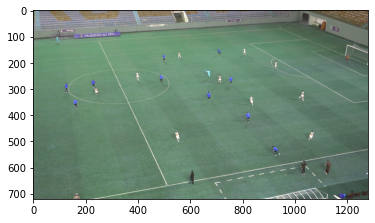

In [64]:
plt.imshow(image)

In [53]:
# import the necessary packages
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import glob
import cv2

index = {}
i = 0
for bbox in sample['bboxes']:
    if bbox['label'] == 'player_team_1' or bbox['label'] == 'player_team_2' or bbox['label'] == 'goalkeeper_team_1' or bbox['label'] == 'goalkeeper_team_2':
        p1, p2 = tuple(map(int, bbox['points'][0])), tuple(map(int, bbox['points'][1]))
        x1, x2, y1, y2 = p1[0], p2[0], p1[1], p2[1]
        print(x1, x2, y1, y2)
        cropped_image = image[y1:y2, x1:x2]
        cv2.imshow('image', cropped_image)
        cv2.waitKey(0) 
        cv2.destroyAllWindows() 
        hist = cv2.calcHist([cropped_image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        index['player_' +  str(i)] = (cropped_image, hist)
        i += 1
        

1191 1206 166 200
1015 1038 305 347
921 932 194 227
802 812 143 173
552 567 156 184
706 719 245 281
826 844 326 366
1052 1073 459 499
541 560 459 503
234 248 293 328
393 407 234 270
914 944 517 556
812 830 388 430
748 762 251 285
665 678 310 345
484 502 244 277
493 509 167 196
221 237 264 297
121 139 277 316
153 171 338 376
704 718 146 170


In [54]:
index.items()

dict_items([('player_0', (array([[[ 78, 100,  81],
        [ 75,  88,  70],
        [117, 130, 112],
        ...,
        [ 85, 106,  92],
        [ 94, 109,  98],
        [ 98, 113, 102]],

       [[ 74,  96,  77],
        [ 79,  92,  74],
        [138, 151, 133],
        ...,
        [ 60,  81,  67],
        [ 96, 111, 100],
        [ 94, 109,  98]],

       [[ 73,  92,  76],
        [ 85,  95,  78],
        [159, 169, 152],
        ...,
        [ 59,  73,  73],
        [ 85,  97,  89],
        [ 94, 106,  98]],

       ...,

       [[ 83, 100,  98],
        [ 80,  95,  93],
        [ 73,  88,  86],
        ...,
        [107, 116, 117],
        [ 94, 106, 105],
        [ 96, 108, 107]],

       [[ 88, 108, 103],
        [ 92, 109, 105],
        [ 85, 102,  98],
        ...,
        [118, 134, 134],
        [ 99, 116, 114],
        [ 82,  99,  97]],

       [[ 86, 106, 101],
        [ 88, 105, 101],
        [ 88, 105, 101],
        ...,
        [ 88, 104, 104],
        [ 87, 104, 102]

## RGB AVERAGE

In [55]:
#cv2.imshow('image', index['player_0'][0])
#cv2.waitKey(0) 
#cv2.destroyAllWindows()
print(index['player_0'][0].shape)
rgb_avg = [(name, index[name][0].mean(axis=0).mean(axis=0)) for name in list(index)]
rgb_avg

(34, 15, 3)


[('player_0', array([105.26666667, 101.49019608,  91.96470588])),
 ('player_1', array([128.47929607, 144.52795031, 130.5010352 ])),
 ('player_2', array([151.75757576, 161.6969697 , 148.34986226])),
 ('player_3', array([161.4       , 175.81666667, 157.93666667])),
 ('player_4', array([143.31190476, 168.34761905, 140.26190476])),
 ('player_5', array([146.94871795, 158.39102564, 141.53632479])),
 ('player_6', array([144.67777778, 162.06527778, 147.14305556])),
 ('player_7', array([142.44761905, 152.89761905, 141.04642857])),
 ('player_8', array([154.88157895, 167.73803828, 150.69497608])),
 ('player_9', array([145.9755102 , 156.86938776, 137.34081633])),
 ('player_10', array([158.90079365, 174.39285714, 154.31746032])),
 ('player_11', array([ 88.33418803, 109.67692308, 120.39059829])),
 ('player_12', array([ 97.54497354, 117.64021164, 144.61507937])),
 ('player_13', array([100.74789916, 127.85084034, 150.02941176])),
 ('player_14', array([ 93.11868132, 115.28131868, 150.47692308])),
 ('pl

In [65]:
from sklearn.cluster import KMeans
# cluster feature vectors
kmeans = KMeans(n_clusters=2, random_state=22)
avg = np.array([rgb_avg[i][1] for i in range(len(rgb_avg))])

kmeans.fit(avg)

# holds the cluster id and the images { id: [images] }
groups = {}
names = np.array([rgb_avg[i][0] for i in range(len(rgb_avg))])
for name, cluster in zip(names,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(name)
    else:
        groups[cluster].append(name)

In [66]:
groups

{1: ['player_0',
  'player_11',
  'player_12',
  'player_13',
  'player_14',
  'player_15',
  'player_16',
  'player_17',
  'player_18',
  'player_19',
  'player_20'],
 0: ['player_1',
  'player_2',
  'player_3',
  'player_4',
  'player_5',
  'player_6',
  'player_7',
  'player_8',
  'player_9',
  'player_10']}

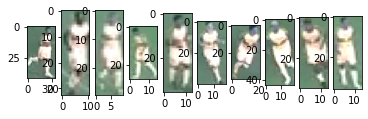

In [67]:
# plt.subplot(1, len(groups[0]), 1)
for i, player in enumerate(groups[0]):
    plt.subplot(1, len(groups[0]), i+1)
    plt.imshow(index[player][0])

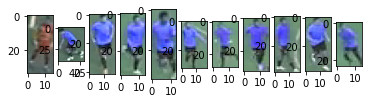

In [68]:
# plt.subplot(1, len(groups[0]), 1)
for i, player in enumerate(groups[1]):
    plt.subplot(1, len(groups[1]), i+1)
    plt.imshow(index[player][0])

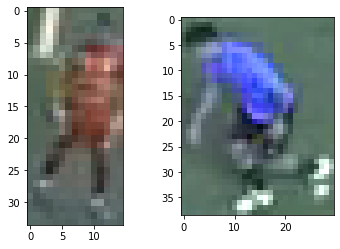

In [63]:
# plt.subplot(1, len(groups[0]), 1)
for i, player in enumerate(groups[2]):
    plt.subplot(1, len(groups[2]), i+1)
    plt.imshow(index[player][0])

## HISTOGRAM DISTANCE

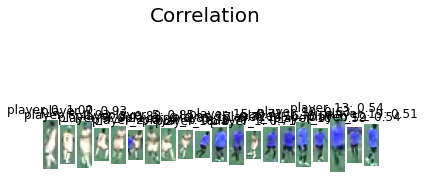

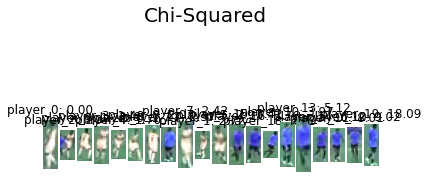

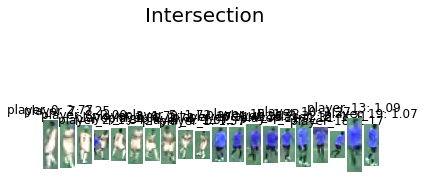

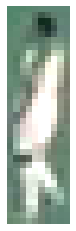

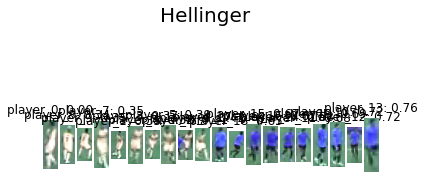

In [39]:
# METHOD #1: UTILIZING OPENCV
# initialize OpenCV methods for histogram comparison
OPENCV_METHODS = (
    ("Correlation", cv2.HISTCMP_CORREL),
    ("Chi-Squared", cv2.HISTCMP_CHISQR),
    ("Intersection", cv2.HISTCMP_INTERSECT),
    ("Hellinger", cv2.HISTCMP_BHATTACHARYYA))
# loop over the comparison methods
for (methodName, method) in OPENCV_METHODS:
    # initialize the results dictionary and the sort
    # direction
    results = {}
    reverse = False
    # if we are using the correlation or intersection
    # method, then sort the results in reverse order
    if methodName in ("Correlation", "Intersection"):
        reverse = True
        
    compare_hist = index['player_0'][1]
    # loop over the index
    for (name, data) in index.items():
        img, hist = data[0], data[1]
        # compute the distance between the two histograms
        # using the method and update the results dictionary
        d = cv2.compareHist(compare_hist, hist, method)
        results[name] = d# sort the results
    results = sorted([(r, name) for (name, r) in results.items()], reverse = reverse)
    
    # show the query image
    fig = plt.figure("Query")
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(index['player_0'][0])
    plt.axis("off")
    # initialize the results figure
    fig = plt.figure("Results: %s" % (methodName))
    fig.suptitle(methodName, fontsize = 20)
    # loop over the results
    for (i, (v, k)) in enumerate(results):
    # show the result
        ax = fig.add_subplot(1, len(index), i + 1)
        ax.set_title("%s: %.2f" % (k, v))
        plt.imshow(index[k][0])
        plt.axis("off")
# show the OpenCV methods
plt.show()


In [43]:

distances = np.array([results[i][0] for i in range(len(results))])
distances

array([0.        , 0.33949486, 0.3461775 , 0.35311482, 0.35472624,
       0.37036805, 0.38432537, 0.39471338, 0.41302018, 0.41689679,
       0.63721567, 0.65397115, 0.66659534, 0.66817893, 0.67924583,
       0.68061297, 0.69191223, 0.7155178 , 0.7189491 , 0.76113982])

In [44]:
from sklearn.cluster import KMeans
# cluster feature vectors
kmeans = KMeans(n_clusters=2, random_state=22)
distances = np.array([results[i][0] for i in range(len(results))])

kmeans.fit(distances.reshape(-1, 1))

# holds the cluster id and the images { id: [images] }
groups = {}
names = np.array([results[i][1] for i in range(len(results))])
for name, cluster in zip(names,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(name)
    else:
        groups[cluster].append(name)

In [45]:
groups

{0: ['player_0',
  'player_8',
  'player_9',
  'player_7',
  'player_1',
  'player_3',
  'player_4',
  'player_5',
  'player_2',
  'player_6'],
 1: ['player_17',
  'player_18',
  'player_15',
  'player_16',
  'player_14',
  'player_11',
  'player_19',
  'player_10',
  'player_12',
  'player_13']}

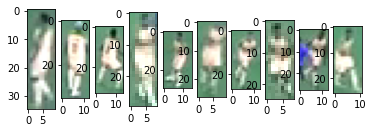

In [46]:
# plt.subplot(1, len(groups[0]), 1)
for i, player in enumerate(groups[0]):
    plt.subplot(1, len(groups[0]), i+1)
    plt.imshow(index[player][0])

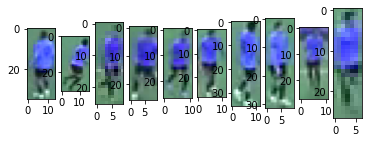

In [47]:
# plt.subplot(1, len(groups[0]), 1)
for i, player in enumerate(groups[1]):
    plt.subplot(1, len(groups[1]), i+1)
    plt.imshow(index[player][0])